## Getting Started

# Model
For the Vision Transformer in Task 0, we will use Google's ViT Base with Patch 16 & Clip 224 which can be found [here](https://huggingface.co/google/vit-base-patch16-224). The model has been trained on ImageNet-21k and fintuned on ImageNet-1k.

In [ ]:
import torch
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Dataset
For Task 1, We will use the CIFAR-10 Dataset. We will also use the AutoImageProcessor provided in the transformers library to preprocess the CIFAR-10 Dataset before using it. Preprocessing mainly includes resizing, converting to tensor, and normalization. A simple collate function will apply these changes to the dataset and feed them into a PyTorch DataLoader

In [ ]:
from transformers import AutoImageProcessor
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

tfms = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

def collate_fn(batch):
    images, labels = zip(*batch)
    inputs = tfms(images=list(images), return_tensors='pt')
    labels = torch.tensor(labels)
    return inputs['pixel_values'], labels


BATCH_SIZE = 256

# Getting CIFAR 10 Dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=None)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=None)

# Setting Up Train and Test Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Files already downloaded and verified
Files already downloaded and verified


## Visualizing Pre Processed Images from the Dataset

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


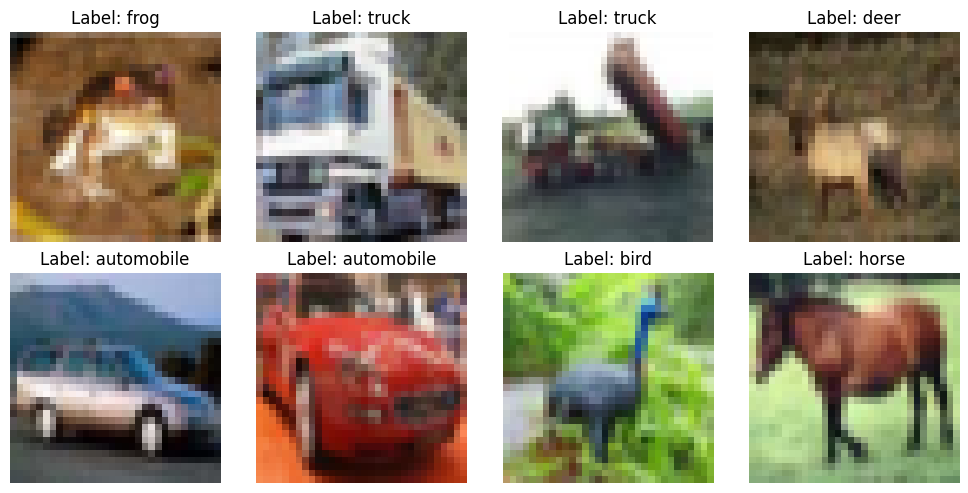

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt


dataset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
classes = dataset.classes

print(classes)

# Set up the subplot grid
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.ravel()

for i in range(8):
    image, label = dataset[i]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {classes[label]}')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

## Visualizing Post Processed Images from the Train Loader

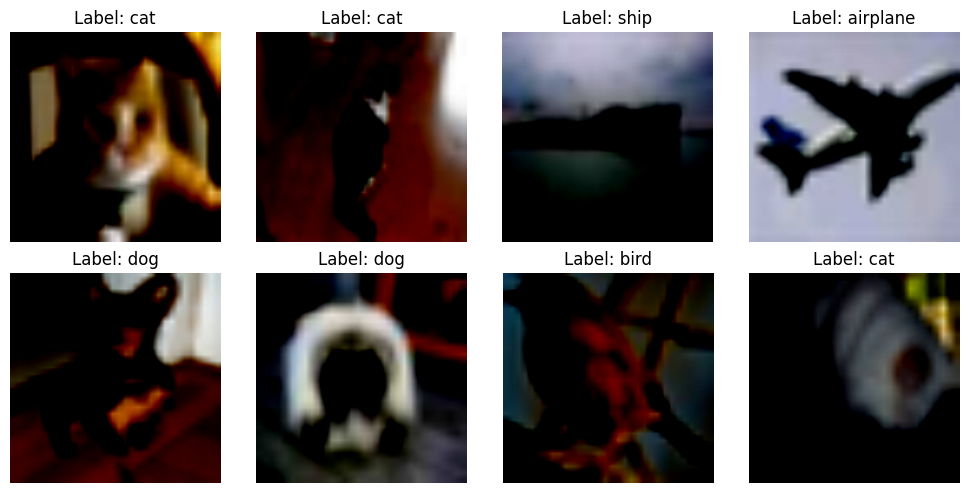

Tensor Shape:  torch.Size([256, 3, 224, 224])


In [ ]:
import random


images, labels = next(iter(train_loader))
firstBatchList = list(zip(images, labels))

# Select random indices for visualization
indices = random.sample(range(len(firstBatchList)), 8)

# Set up the subplot grid
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.ravel()

for i, idx in enumerate(indices):
    image, label = firstBatchList[idx]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {classes[label.item()]}')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

print("Tensor Shape: ", next(iter(train_loader))[0].shape)

## Fine Tuning the Classification Head.

First we will freeze the feature extractor, and only train on the Classification Head for 3 epochs. We will also define our train loop here.

In [ ]:
# Freeze the feature extractor parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classification head parameters
for param in model.classifier.parameters():
    param.requires_grad = True


# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

# Set up training loop
num_epochs = 3
loss_fn = torch.nn.CrossEntropyLoss()

print(f"Batches: {len(train_loader)}")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=inputs)

        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        print(f"Loss for Batch {batch_idx}: {loss.item()}")


        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(pixel_values=inputs)
            _, predicted = torch.max(outputs.logits.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")



Batches: 196
Loss for Batch 0: 10.289806365966797
Loss for Batch 1: 10.02028751373291
Loss for Batch 2: 9.73443603515625
Loss for Batch 3: 9.585464477539062
Loss for Batch 4: 9.429060935974121
Loss for Batch 5: 9.254581451416016
Loss for Batch 6: 8.860454559326172
Loss for Batch 7: 8.612356185913086
Loss for Batch 8: 8.715837478637695
Loss for Batch 9: 8.39574909210205
Loss for Batch 10: 8.325508117675781
Loss for Batch 11: 7.960295677185059
Loss for Batch 12: 7.788450241088867
Loss for Batch 13: 7.7167067527771
Loss for Batch 14: 7.405331611633301
Loss for Batch 15: 7.256567478179932
Loss for Batch 16: 6.942532539367676
Loss for Batch 17: 7.089871406555176
Loss for Batch 18: 6.777234077453613
Loss for Batch 19: 6.493851184844971
Loss for Batch 20: 6.376607894897461
Loss for Batch 21: 6.223388671875
Loss for Batch 22: 5.878060817718506
Loss for Batch 23: 5.632204055786133
Loss for Batch 24: 5.53387975692749
Loss for Batch 25: 5.425793170928955
Loss for Batch 26: 5.091004371643066
Loss 

## Final Accuracy of the Model on test split
We can see that in IID conditions, our ViT Base gives a classification accuracy of over 96%.

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=inputs)
        _, predicted = torch.max(outputs.logits.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc = 100 * correct / total
print(f"Test Accuracy: {acc:.2f}%")

NameError: name 'device' is not defined

## Saving the Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MODEL_SAVE_PATH = '/content/drive/MyDrive/AdvMLPA1-01-VIT.pth' # Assumes that Google Drive is Mounted and DataSet Uploaded there

torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Testing on OOD Data
We will now evaluate on the PACS dataset that represents a Covariate Shift. i.e same classes but images coming form a different distribution.

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

pacs_dataset = load_dataset("flwrlabs/pacs")
pacs_dataset = pacs_dataset.with_format("torch")

data_loader = DataLoader(pacs_dataset["train"], batch_size=BATCH_SIZE, shuffle=True)

## Visualizing a few samples from the PACS dataset

Preprocessing using AutoImageProcessor has been applied

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']
Image Shape: torch.Size([256, 3, 227, 227])
Labels Shape: torch.Size([256])


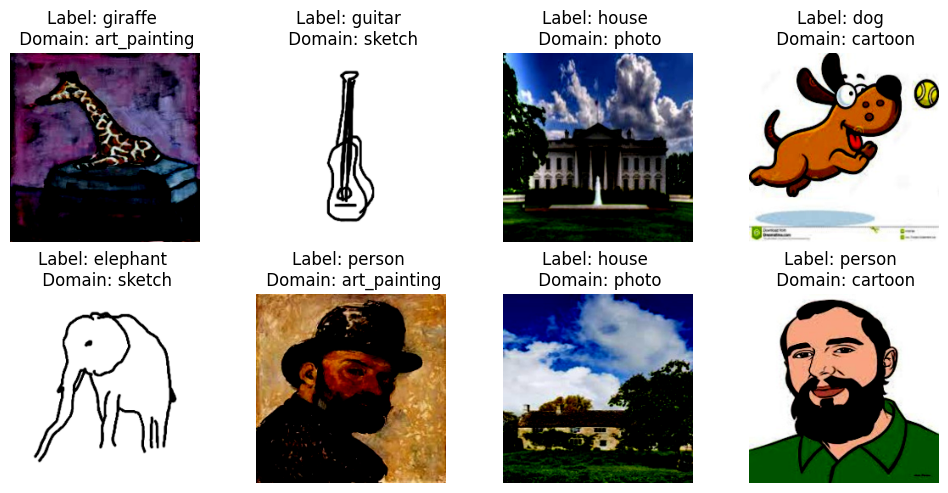

In [ ]:
import random
import matplotlib.pyplot as plt

classes = pacs_dataset['train'].features['label'].names

print(classes)

print(f"Image Shape: {next(iter(data_loader))['image'].shape}")
print(f"Labels Shape: {next(iter(data_loader))['label'].shape}")

BATCH1 = next(iter(data_loader))
inputs = tfms(images=list(BATCH1["image"]), return_tensors='pt')
inputs = inputs["pixel_values"]
# Select random indices for visualization

# Set up the subplot grid
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.ravel()

for idx in range(8):
    image = inputs[idx]
    label = BATCH1["label"][idx]
    domain = BATCH1["domain"][idx]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying

    axes[idx].imshow(image)
    axes[idx].set_title(f'Label: {classes[label]} \n Domain: {domain}')
    axes[idx].axis('off')  # Hide axis

plt.tight_layout()
plt.show()


## Fine Tuning the Classification Head for PACS

We will finetune the classification head again using AdamW and run for 3 epochs. Have also used the SAME learning rate here. Although, a higher LR - 10x the previous one, we were able to achieve 91% accuracy on test. would probably result in better classification accuracy.

In [ ]:
# Freeze the feature extractor parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classification head parameters
for param in model.classifier.parameters():
    param.requires_grad = True


# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

# Set up training loop
num_epochs = 3
loss_fn = torch.nn.CrossEntropyLoss()

print(f"Batches: {len(data_loader)}")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(data_loader):
        inputs = batch["image"]
        inputs = tfms(images=list(inputs), return_tensors='pt')
        inputs = inputs["pixel_values"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=inputs)

        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        print(f"Loss for Batch {batch_idx}: {loss.item()}")


        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


from google.colab import drive
drive.mount('/content/drive')

MODEL_SAVE_PATH = '/content/drive/MyDrive/AdvMLPA1-VIT-OOD-PACS.pth' # Assumes that Google Drive is Mounted and DataSet Uploaded there

torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Batches: 40
Loss for Batch 0: 9.648993492126465
Loss for Batch 1: 8.097923278808594
Loss for Batch 2: 6.582336902618408
Loss for Batch 3: 4.746155738830566
Loss for Batch 4: 3.615485429763794
Loss for Batch 5: 3.1800129413604736
Loss for Batch 6: 2.3227505683898926
Loss for Batch 7: 1.8308123350143433
Loss for Batch 8: 1.7416974306106567
Loss for Batch 9: 1.3609381914138794
Loss for Batch 10: 1.046845555305481
Loss for Batch 11: 0.9071596264839172
Loss for Batch 12: 0.932355523109436
Loss for Batch 13: 0.7837449312210083
Loss for Batch 14: 0.695615291595459
Loss for Batch 15: 0.7214512228965759
Loss for Batch 16: 0.5755351185798645
Loss for Batch 17: 0.6667229533195496
Loss for Batch 18: 0.5960991978645325
Loss for Batch 19: 0.5447195768356323
Loss for Batch 20: 0.5367845296859741
Loss for Batch 21: 0.5450143218040466
Loss for Batch 22: 0.4754871726036072
Loss for Batch 23: 0.5586956739425659
Loss for Batch 24: 0.5165888071060181
Loss for Batch 25: 0.48639166355133057
Loss for Batch 26

## Evaluating the Model on Pacs

PACS has different classes than CIFAR10, we have to retrain the classification head for 3 epochs otherwise accuracy will be very low. Once this is done, we will then evaluate the model on the test split of this dataset.

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  model.eval()
  for idx, batch in enumerate(data_loader):

    inputs = batch["image"]
    inputs = tfms(images=list(inputs), return_tensors='pt')
    inputs = inputs["pixel_values"].to(device)
    labels = batch["label"].to(device)

    outputs = model(pixel_values=inputs)
    _, predicted = torch.max(outputs.logits.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    print(f"Batch {idx}: {correct}/{total} Correct")

acc = 100 * correct / total
print(f"Accuracy on PACS: {acc:.2f}%")

Batch 0: 240/256 Correct
Batch 1: 472/512 Correct
Batch 2: 704/768 Correct
Batch 3: 937/1024 Correct
Batch 4: 1174/1280 Correct
Batch 5: 1401/1536 Correct
Batch 6: 1634/1792 Correct
Batch 7: 1867/2048 Correct
Batch 8: 2105/2304 Correct
Batch 9: 2333/2560 Correct
Batch 10: 2572/2816 Correct
Batch 11: 2810/3072 Correct
Batch 12: 3047/3328 Correct
Batch 13: 3283/3584 Correct
Batch 14: 3520/3840 Correct
Batch 15: 3751/4096 Correct
Batch 16: 3983/4352 Correct
Batch 17: 4221/4608 Correct
Batch 18: 4461/4864 Correct
Batch 19: 4696/5120 Correct
Batch 20: 4932/5376 Correct
Batch 21: 5159/5632 Correct
Batch 22: 5400/5888 Correct
Batch 23: 5638/6144 Correct
Batch 24: 5882/6400 Correct
Batch 25: 6124/6656 Correct
Batch 26: 6365/6912 Correct
Batch 27: 6597/7168 Correct
Batch 28: 6830/7424 Correct
Batch 29: 7063/7680 Correct
Batch 30: 7295/7936 Correct
Batch 31: 7532/8192 Correct
Batch 32: 7768/8448 Correct
Batch 33: 7998/8704 Correct
Batch 34: 8232/8960 Correct
Batch 35: 8468/9216 Correct
Batch 36:

##  Fine Tuning on PACHS using the SAME lr


In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Freeze the feature extractor parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classification head parameters
for param in model.classifier.parameters():
    param.requires_grad = True


# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

# Set up training loop
num_epochs = 3
loss_fn = torch.nn.CrossEntropyLoss()

print(f"Batches: {len(data_loader)}")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(data_loader):
        inputs = batch["image"]
        inputs = tfms(images=list(inputs), return_tensors='pt')
        inputs = inputs["pixel_values"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=inputs)

        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        print(f"Loss for Batch {batch_idx}: {loss.item()}")


        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


from google.colab import drive
drive.mount('/content/drive')

MODEL_SAVE_PATH = '/content/drive/MyDrive/AdvMLPA1-VIT-OOD-PACS-SameLR.pth' # Assumes that Google Drive is Mounted and DataSet Uploaded there

torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)



Batches: 40
Loss for Batch 0: 9.806635856628418
Loss for Batch 1: 9.373685836791992
Loss for Batch 2: 9.399190902709961
Loss for Batch 3: 9.13320255279541
Loss for Batch 4: 9.114142417907715
Loss for Batch 5: 8.99537467956543
Loss for Batch 6: 8.630319595336914
Loss for Batch 7: 8.499995231628418
Loss for Batch 8: 8.275825500488281
Loss for Batch 9: 8.184774398803711
Loss for Batch 10: 7.866636276245117
Loss for Batch 11: 7.8055548667907715
Loss for Batch 12: 7.8015642166137695
Loss for Batch 13: 7.55086088180542
Loss for Batch 14: 7.47970724105835
Loss for Batch 15: 7.146576881408691
Loss for Batch 16: 7.010447978973389
Loss for Batch 17: 7.058262825012207
Loss for Batch 18: 6.795124530792236
Loss for Batch 19: 6.6510820388793945
Loss for Batch 20: 6.392058372497559
Loss for Batch 21: 6.404626369476318
Loss for Batch 22: 6.290040969848633
Loss for Batch 23: 6.208116054534912
Loss for Batch 24: 6.019527912139893
Loss for Batch 25: 5.5559773445129395
Loss for Batch 26: 5.702921390533447

## Evaluation

In [ ]:
print(pacs_dataset)

correct = 0
total = 0

with torch.no_grad():
  model.eval()
  for idx, batch in enumerate(data_loader):

    inputs = batch["image"]
    inputs = tfms(images=list(inputs), return_tensors='pt')
    inputs = inputs["pixel_values"].to(device)
    labels = batch["label"].to(device)

    outputs = model(pixel_values=inputs)
    _, predicted = torch.max(outputs.logits.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    print(f"Batch {idx}: {correct}/{total} Correct")

acc = 100 * correct / total
print(f"Accuracy on PACS: {acc:.2f}%")

DatasetDict({
    train: Dataset({
        features: ['image', 'domain', 'label'],
        num_rows: 9991
    })
})
Batch 0: 184/256 Correct
Batch 1: 375/512 Correct
Batch 2: 554/768 Correct
Batch 3: 748/1024 Correct
Batch 4: 939/1280 Correct
Batch 5: 1133/1536 Correct
Batch 6: 1317/1792 Correct
Batch 7: 1500/2048 Correct
Batch 8: 1682/2304 Correct
Batch 9: 1861/2560 Correct
Batch 10: 2058/2816 Correct
Batch 11: 2236/3072 Correct
Batch 12: 2426/3328 Correct
Batch 13: 2617/3584 Correct
Batch 14: 2796/3840 Correct
Batch 15: 2985/4096 Correct
Batch 16: 3173/4352 Correct
Batch 17: 3353/4608 Correct
Batch 18: 3533/4864 Correct
Batch 19: 3719/5120 Correct
Batch 20: 3907/5376 Correct
Batch 21: 4089/5632 Correct
Batch 22: 4269/5888 Correct
Batch 23: 4440/6144 Correct
Batch 24: 4628/6400 Correct
Batch 25: 4820/6656 Correct
Batch 26: 5016/6912 Correct
Batch 27: 5199/7168 Correct
Batch 28: 5388/7424 Correct
Batch 29: 5573/7680 Correct
Batch 30: 5744/7936 Correct
Batch 31: 5922/8192 Correct
Batch 

## Evaluation on SVHN

SVHN represents a semantic shift



['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Image Shape: torch.Size([512, 3, 32, 32])
Labels Shape: torch.Size([512])


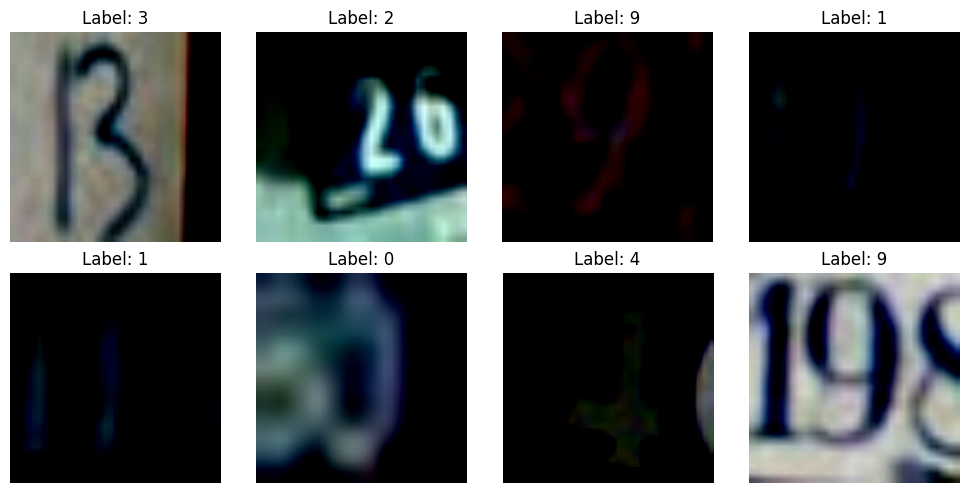

In [ ]:
from datasets import load_dataset

ds = load_dataset("ufldl-stanford/svhn", "cropped_digits")
ds = ds.with_format("torch")

train_loader = DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False)


import random
import matplotlib.pyplot as plt

classes = ds['train'].features['label'].names

print(classes)

print(f"Image Shape: {next(iter(train_loader))['image'].shape}")
print(f"Labels Shape: {next(iter(train_loader))['label'].shape}")

BATCH1 = next(iter(train_loader))
inputs = tfms(images=list(BATCH1["image"]), return_tensors='pt')
inputs = inputs["pixel_values"]
# Select random indices for visualization

# Set up the subplot grid
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.ravel()

for idx in range(8):
    image = inputs[idx]
    label = BATCH1["label"][idx]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying

    axes[idx].imshow(image)
    axes[idx].set_title(f'Label: {classes[label]}')
    axes[idx].axis('off')  # Hide axis

plt.tight_layout()
plt.show()


Finetuning SVHN

In [ ]:
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

# Freeze the feature extractor parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classification head parameters
for param in model.classifier.parameters():
    param.requires_grad = True


# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set up optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

# Set up training loop
num_epochs = 3
loss_fn = torch.nn.CrossEntropyLoss()

print(f"Batches: {len(train_loader)}")

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        inputs = batch["image"]
        inputs = tfms(images=list(inputs), return_tensors='pt')
        inputs = inputs["pixel_values"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=inputs)

        loss = loss_fn(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        print(f"Loss for Batch {batch_idx}: {loss.item()}")


        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


from google.colab import drive
drive.mount('/content/drive')

MODEL_SAVE_PATH = '/content/drive/MyDrive/AdvMLPA1-VIT-OOD-SVHN-SameLR.pth' # Assumes that Google Drive is Mounted and DataSet Uploaded there

torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)



Batches: 144
Loss for Batch 0: 8.836607933044434
Loss for Batch 1: 8.494226455688477
Loss for Batch 2: 8.353768348693848
Loss for Batch 3: 8.230791091918945
Loss for Batch 4: 7.948845863342285
Loss for Batch 5: 7.642582416534424
Loss for Batch 6: 7.451670169830322
Loss for Batch 7: 7.123709678649902
Loss for Batch 8: 7.0394062995910645
Loss for Batch 9: 6.781435966491699
Loss for Batch 10: 6.488545894622803
Loss for Batch 11: 6.300038814544678
Loss for Batch 12: 6.164426803588867
Loss for Batch 13: 6.006107330322266
Loss for Batch 14: 5.843038082122803
Loss for Batch 15: 5.529996871948242
Loss for Batch 16: 5.338454246520996
Loss for Batch 17: 5.0942158699035645
Loss for Batch 18: 4.991457462310791
Loss for Batch 19: 4.647397994995117
Loss for Batch 20: 4.606388568878174
Loss for Batch 21: 4.345056533813477
Loss for Batch 22: 4.31504487991333
Loss for Batch 23: 4.045663833618164
Loss for Batch 24: 3.9745893478393555
Loss for Batch 25: 3.850095748901367
Loss for Batch 26: 3.640729904174

ValueError: mount failed

## Evaluation on SVHN

In [ ]:
correct = 0
total = 0

with torch.no_grad():
  model.eval()
  for idx, batch in enumerate(test_loader):

    inputs = batch["image"]
    inputs = tfms(images=list(inputs), return_tensors='pt')
    inputs = inputs["pixel_values"].to(device)
    labels = batch["label"].to(device)

    outputs = model(pixel_values=inputs)
    _, predicted = torch.max(outputs.logits.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    print(f"Batch {idx}: {correct}/{total} Correct")

acc = 100 * correct / total
print(f"Accuracy on SVHN: {acc:.2f}%")

Batch 0: 202/512 Correct
Batch 1: 398/1024 Correct
Batch 2: 625/1536 Correct
Batch 3: 824/2048 Correct
Batch 4: 1066/2560 Correct
Batch 5: 1298/3072 Correct
Batch 6: 1506/3584 Correct
Batch 7: 1726/4096 Correct
Batch 8: 1950/4608 Correct
Batch 9: 2169/5120 Correct
Batch 10: 2383/5632 Correct
Batch 11: 2602/6144 Correct
Batch 12: 2822/6656 Correct
Batch 13: 3038/7168 Correct
Batch 14: 3247/7680 Correct
Batch 15: 3468/8192 Correct
Batch 16: 3701/8704 Correct
Batch 17: 3932/9216 Correct
Batch 18: 4164/9728 Correct
Batch 19: 4393/10240 Correct
Batch 20: 4628/10752 Correct
Batch 21: 4854/11264 Correct
Batch 22: 5081/11776 Correct
Batch 23: 5296/12288 Correct
Batch 24: 5492/12800 Correct
Batch 25: 5728/13312 Correct
Batch 26: 5956/13824 Correct
Batch 27: 6171/14336 Correct
Batch 28: 6415/14848 Correct
Batch 29: 6623/15360 Correct
Batch 30: 6847/15872 Correct
Batch 31: 7073/16384 Correct
Batch 32: 7315/16896 Correct
Batch 33: 7528/17408 Correct
Batch 34: 7765/17920 Correct
Batch 35: 7973/1843

SVHN gives a very poor accuracy of only 43.17% which is a major hit on our current lr.

# Preparing CIFAR Dataset to Inject Noise

We'll be injecting random gaussian noise with mean=0, std=1 at a 32x32 patch


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Files already downloaded and verified
Files already downloaded and verified


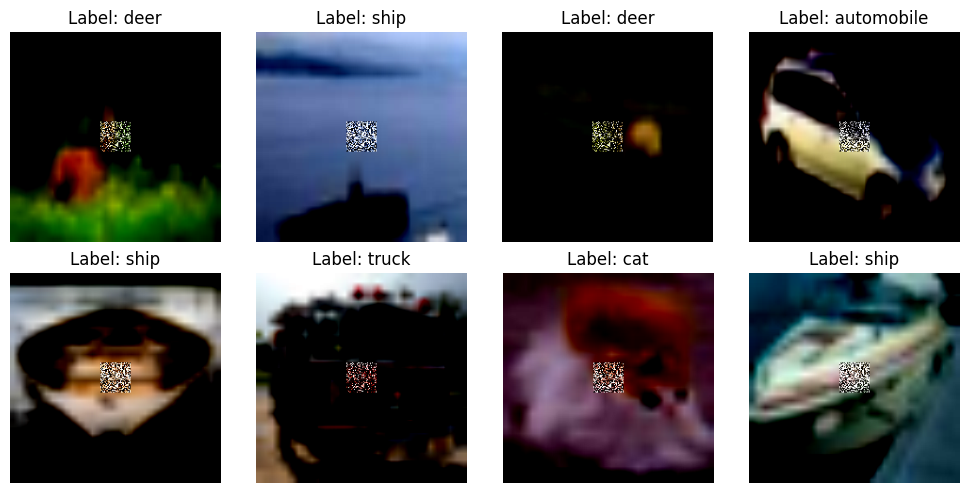

Tensor Shape:  torch.Size([256, 3, 224, 224])


In [ ]:
import torch
from transformers import AutoImageProcessor
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt


tfms = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
BATCH_SIZE = 256

def noiseInjector(batch, patchSize = 32):
    if batch.shape != (batch.size(0), 3, 224, 224):
        raise ValueError("The input tensor must be of shape (256, 3, 224, 224).")

    noise = torch.normal(mean=0, std=1, size=(patchSize, patchSize))

    # Padding with Zeros
    pad_size = (224 - patchSize) // 2
    padded_noise = F.pad(noise, (pad_size, pad_size, pad_size, pad_size), "constant", 0);

    padded_noise = padded_noise.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 224, 223)
    padded_noise = padded_noise.expand(batch.size(0), batch.size(1), -1, -1)  # Shape: (256, 3, 224, 224)

    # Add the noise to the input batch
    noisy_batch = batch + padded_noise

    return noisy_batch



def collate_fn(batch):
    images, labels = zip(*batch)
    inputs = tfms(images=list(images), return_tensors='pt')
    inputs['pixel_values'] = noiseInjector(inputs['pixel_values'])
    labels = torch.tensor(labels)
    return inputs['pixel_values'], labels



# Getting CIFAR 10 Dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=None)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=None)

# Setting Up Train and Test Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

classes = train_dataset.classes

images, labels = next(iter(train_loader))
firstBatchList = list(zip(images, labels))

# Select random indices for visualization
indices = random.sample(range(len(firstBatchList)), 8)

# Set up the subplot grid
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.ravel()

for i, idx in enumerate(indices):
    image, label = firstBatchList[idx]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {classes[label.item()]}')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

print("Tensor Shape: ", next(iter(train_loader))[0].shape)

## Evaluating the Model on the Noise Data

Accurcy of the Model has dropped to 92.7% with a 32x32 Noise Patch at the center
Accuracy of the Model has dropped to __ with a 64 x 64 Noise Patch at the center


In [ ]:
## Import Fine Tuned Model Params for CIFAR
from transformers import ViTForImageClassification
from google.colab import drive

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

drive.mount('/content/drive')
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
CIFAR10_state_dict = torch.load("/content/drive/MyDrive/AdvMLPA1-01-VIT.pth", map_location=device)
model.load_state_dict(CIFAR10_state_dict, strict=False)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-10-64fc3530108a>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  CIFAR10_state_dict = torch.load("/content/drive/MyDrive/AdvMLPA1-01-VIT.pth", map_location=d

<All keys matched successfully>

In [ ]:
model.eval()
correct = 0
total = 0
model.to(device)
print(len(test_loader))
with torch.no_grad():
    for batch, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=inputs)
        _, predicted = torch.max(outputs.logits.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f"Batch {batch}: {correct}/{total}")

acc = 100 * correct / totalprint(f"Test Accuracy: {acc:.2f}%")

40
Batch 0: 237/256
Batch 1: 471/512
Batch 2: 715/768
Batch 3: 952/1024
Batch 4: 1190/1280
Batch 5: 1430/1536
Batch 6: 1657/1792
Batch 7: 1898/2048
Batch 8: 2126/2304
Batch 9: 2361/2560
Batch 10: 2605/2816
Batch 11: 2830/3072
Batch 12: 3062/3328
Batch 13: 3293/3584
Batch 14: 3530/3840
Batch 15: 3770/4096
Batch 16: 4007/4352
Batch 17: 4248/4608
Batch 18: 4480/4864
Batch 19: 4722/5120
Batch 20: 4964/5376
Batch 21: 5204/5632
Batch 22: 5445/5888
Batch 23: 5690/6144
Batch 24: 5930/6400
Batch 25: 6167/6656
Batch 26: 6406/6912
Batch 27: 6639/7168
Batch 28: 6877/7424
Batch 29: 7104/7680
Batch 30: 7345/7936
Batch 31: 7586/8192
Batch 32: 7821/8448
Batch 33: 8053/8704
Batch 34: 8286/8960
Batch 35: 8530/9216
Batch 36: 8770/9472
Batch 37: 9009/9728
Batch 38: 9254/9984
Batch 39: 9270/10000
Test Accuracy: 92.70%


Files already downloaded and verified


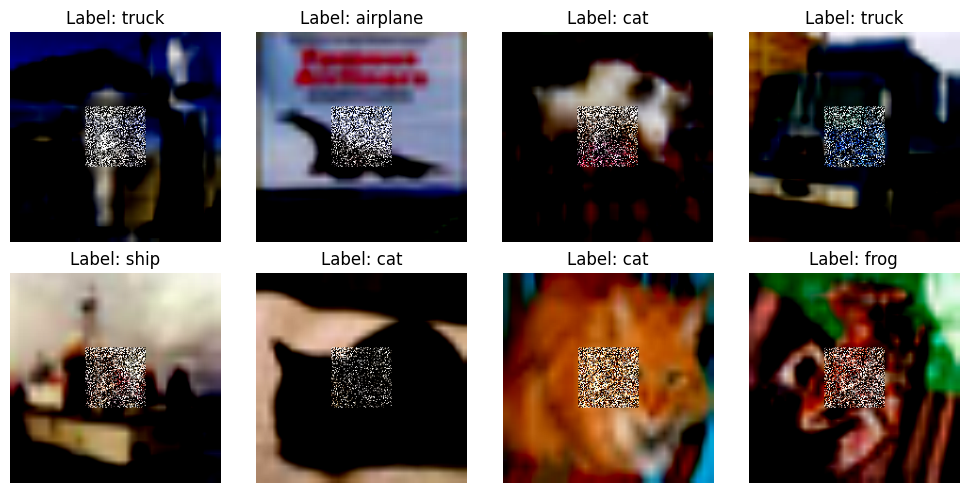

Tensor Shape:  torch.Size([256, 3, 224, 224])


In [ ]:
# Patch Size of 64 for Noise
def collate_fn(batch):
    images, labels = zip(*batch)
    inputs = tfms(images=list(images), return_tensors='pt')
    inputs['pixel_values'] = noiseInjector(inputs['pixel_values'], 64)
    labels = torch.tensor(labels)
    return inputs['pixel_values'], labels


test_dataset = CIFAR10(root='./data', train=False, download=True, transform=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

classes = test_dataset.classes

images, labels = next(iter(test_loader))
firstBatchList = list(zip(images, labels))

# Select random indices for visualization
indices = random.sample(range(len(firstBatchList)), 8)

# Set up the subplot grid
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
axes = axes.ravel()

for i, idx in enumerate(indices):
    image, label = firstBatchList[idx]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {classes[label.item()]}')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

## Evaluating Again


In [ ]:
model.eval()
correct = 0
total = 0
model.to(device)
print(len(test_loader))
with torch.no_grad():
    for batch, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(pixel_values=inputs)
        _, predicted = torch.max(outputs.logits.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f"Batch {batch}: {correct}/{total}")


40
Batch 0: 210/256
Batch 1: 421/512
Batch 2: 638/768
Batch 3: 858/1024
Batch 4: 1072/1280
Batch 5: 1289/1536
Batch 6: 1501/1792
Batch 7: 1715/2048
Batch 8: 1923/2304
Batch 9: 2122/2560
Batch 10: 2329/2816
Batch 11: 2535/3072
Batch 12: 2741/3328
Batch 13: 2943/3584
Batch 14: 3152/3840
Batch 15: 3358/4096
Batch 16: 3570/4352
Batch 17: 3756/4608
Batch 18: 3951/4864
Batch 19: 4173/5120
Batch 20: 4389/5376
Batch 21: 4604/5632
Batch 22: 4811/5888
Batch 23: 5023/6144
Batch 24: 5230/6400
Batch 25: 5434/6656
Batch 26: 5644/6912
Batch 27: 5858/7168
Batch 28: 6056/7424
Batch 29: 6259/7680
Batch 30: 6470/7936
Batch 31: 6678/8192
Batch 32: 6890/8448
Batch 33: 7088/8704
Batch 34: 7290/8960
Batch 35: 7503/9216
Batch 36: 7708/9472
Batch 37: 7932/9728
Batch 38: 8131/9984
Batch 39: 8144/10000


NameError: name 'totalprint' is not defined

In [ ]:
acc = 100 * correct / total
print(f"Test Accuracy: {acc:.2f}%")

Test Accuracy: 81.44%


## Setup Code for CNN

Dataset Preperation

In [ ]:
import torch

class CenterPatchGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, patch_size=64):
        """
        Initialize the transform.

        Parameters:
        - mean (float): Mean of the Gaussian noise.
        - std (float): Standard deviation of the Gaussian noise.
        - patch_size (int): Size of the center patch to which noise is added.
        """
        self.mean = mean
        self.std = std
        self.patch_size = patch_size

    def __call__(self, img_tensor):
        """
        Apply the transform to a tensor image.

        Parameters:
        - img_tensor (Tensor): Image tensor of shape (C, H, W), values in [0, 1].

        Returns:
        - img_tensor (Tensor): Transformed image tensor with noise added to the center patch.
        """
        # Ensure img_tensor is a tensor
        if not torch.is_tensor(img_tensor):
            raise TypeError("Input should be a Tensor.")

        # Get image dimensions
        _, h, w = img_tensor.shape

        # Ensure image is large enough
        if h < self.patch_size or w < self.patch_size:
            raise ValueError("Image size should be at least as big as the patch size.")

        # Compute center coordinates
        center_h = h // 2
        center_w = w // 2

        # Compute top-left coordinates of the patch
        patch_half = self.patch_size // 2
        top = center_h - patch_half
        left = center_w - patch_half

        # Ensure indices are within image dimensions
        top = max(top, 0)
        left = max(left, 0)

        # Compute bottom-right coordinates of the patch
        bottom = top + self.patch_size
        right = left + self.patch_size

        # Adjust if patch goes beyond image boundaries
        bottom = min(bottom, h)
        right = min(right, w)

        # Slicing indices
        h_indices = slice(top, bottom)
        w_indices = slice(left, right)

        # Generate Gaussian noise
        noise = torch.randn_like(img_tensor[:, h_indices, w_indices]) * self.std + self.mean

        # Add noise to the patch
        img_tensor[:, h_indices, w_indices] += noise

        # Clip the values to be between 0 and 1
        img_tensor = torch.clamp(img_tensor, 0.0, 1.0)

        return img_tensor


In [ ]:

# Transformations
transform = transforms.Compose([
    transforms.Resize(224),  # resize to default vgg16 input size
    transforms.ToTensor(),
    CenterPatchGaussianNoise(mean=0.0, std=1.0, patch_size=64),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [ ]:
next(iter(test_loader))[1].shape

torch.Size([64])

Displaying this

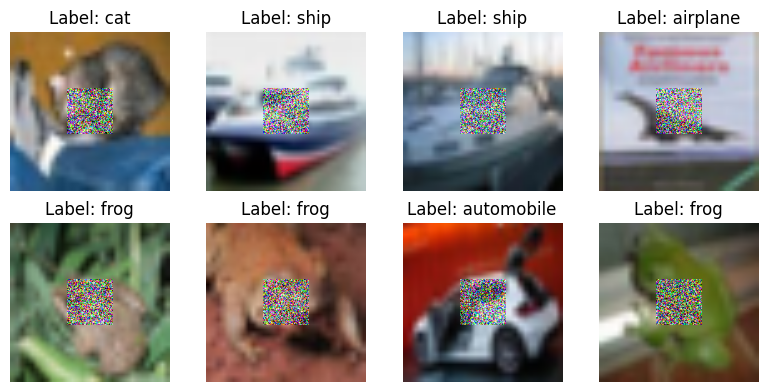

In [ ]:
import matplotlib.pyplot as plt

classes = test_dataset.classes
images, labels = next(iter(test_loader))

# Set up the subplot grid
fig, axes = plt.subplots(2, 4, figsize=(8, 4))
axes = axes.ravel()

for i in range(8):
    image = images[i]
    label = labels[i]
    image = image.permute(1, 2, 0)  # Adjusting dimensions for displaying
    axes[i].imshow(image)
    axes[i].set_title(f'{classes[label.item()]}')
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

Loading the Model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = torch.nn.Linear(4096, 10)
vgg16.to(device)
vgg_state_dict = torch.load("/content/drive/MyDrive/vgg16_t2_cifar10.pth", map_location=device)
vgg16.load_state_dict(vgg_state_dict, strict=False)

<ipython-input-24-122db57664ad>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_state_dict = torch.load("/content/drive/MyDrive/vgg16_t2_cifar10.pth", map_location=devi

<All keys matched successfully>

Running Inference

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            print(f"{correct}/{total}")

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

accuracy = evaluate_model(vgg16, test_loader)
print(f"Accuracy on Noise for VGG: {accuracy}")

29/64
57/128
84/192
106/256
138/320
167/384
195/448
218/512
249/576
277/640
306/704
331/768
350/832
377/896
408/960
437/1024
475/1088
497/1152
525/1216
555/1280
581/1344
607/1408
626/1472
648/1536
670/1600
697/1664
721/1728
748/1792
775/1856
811/1920
833/1984
855/2048
886/2112
917/2176
943/2240
973/2304
993/2368
1021/2432
1051/2496
1073/2560
1103/2624
1134/2688
1164/2752
1188/2816
1216/2880
1244/2944
1274/3008
1300/3072
1325/3136
1355/3200
1381/3264
1409/3328
1433/3392
1460/3456
1484/3520
1505/3584
1532/3648
1563/3712
1586/3776
1615/3840
1637/3904
1664/3968
1690/4032
1714/4096
1740/4160
1769/4224
1792/4288
1820/4352
1855/4416
1886/4480
1917/4544
1937/4608
1961/4672
1989/4736
2013/4800
2041/4864
